# Text Classification TF-IDF Training Testing

In [1]:
import pandas as pd
data_df = pd.read_csv('Top10_Cancer_1.csv', encoding='utf-8')

In [2]:
data_df = data_df[['Article', 'Clean Article', 'ClassID', 'Class']]
data_df.head(10)

,Article,Clean Article,ClassID,Class
0,Optimal adjuvant therapy in clinically N2 non-...,optimal adjuvant therapy clinically n non smal...,1,lung
1,Assessment of interpatient heterogeneity in tu...,assessment interpatient heterogeneity tumor ra...,1,lung
2,[Current problems in the combined therapy of l...,current problem combine therapy lung cancer pa...,1,lung
3,Effect of therapeutic irradiation on lymphocyt...,effect therapeutic irradiation lymphocyte tran...,1,lung
4,Use of intensive care in patients with nonrese...,use intensive care patient nonresectable lung ...,1,lung
5,Establishment of a drug sensitivity panel usin...,establishment drug sensitivity panel use human...,1,lung
6,Effect of gefitinib re-challenge to initial ge...,effect gefitinib challenge initial gefitinib r...,1,lung
7,[Exposed workers to lung cancer risk. An estim...,expose worker lung cancer risk estimation use ...,1,lung
8,Cytology nomenclature and 2015 World Health Or...,cytology nomenclature world health organizatio...,1,lung
9,[Repeated surgery for lung cancer] -,repeat surgery lung cancer,1,lung


In [3]:
import numpy as np
from sklearn.model_selection import train_test_split

train_corpus, test_corpus, train_label_nums, test_label_nums, train_label_names, test_label_names =\
                                 train_test_split(np.array(data_df['Clean Article']), np.array(data_df['ClassID']),
                                                       np.array(data_df['Class']), test_size=0.33, random_state=42)

train_corpus.shape, test_corpus.shape

((6700,), (3300,))

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# build BOW features on train articles
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0)
tv_train_features = tv.fit_transform(train_corpus)

In [5]:
# transform test articles into features
tv_test_features = tv.transform(test_corpus)

In [6]:
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

TFIDF model:> Train features shape: (6700, 49221)  Test features shape: (3300, 49221)


# Using Naive Bayes

In [7]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

mnb = MultinomialNB(alpha=1)
mnb.fit(tv_train_features, train_label_names)
mnb_tfidf_cv_scores = cross_val_score(mnb, tv_train_features, train_label_names, cv=5)
mnb_tfidf_cv_mean_score = np.mean(mnb_tfidf_cv_scores)
print('Train Score (5-fold):', mnb_tfidf_cv_scores)
print('Average Train Score:', mnb_tfidf_cv_mean_score)
mnb_tfidf_test_score = mnb.score(tv_test_features, test_label_names)
print('Test Accuracy:', mnb_tfidf_test_score)

Train Score (5-fold): [0.91940299 0.92537313 0.9141791  0.93059701 0.92313433]
Average Train Score: 0.9225373134328357
Test Accuracy: 0.9106060606060606


In [8]:
import model_evaluation_utils as meu
mnb_predictions = mnb.predict(tv_test_features)
unique_classes = list(set(test_label_names))
meu.get_metrics(true_labels=test_label_names, predicted_labels=mnb_predictions)
meu.display_classification_report(true_labels=test_label_names, 
                                  predicted_labels=mnb_predictions, classes=unique_classes)

Accuracy: 0.9106
Precision: 0.9179
Recall: 0.9106
F1 Score: 0.9107
              precision    recall  f1-score   support

    prostate       0.93      0.98      0.95       332
     thyroid       0.98      0.96      0.97       353
  oesophagus       0.89      0.89      0.89       319
        lung       0.97      0.90      0.94       345
       liver       0.84      0.95      0.89       323
cervix_uteri       0.97      0.87      0.92       320
     stomach       0.99      0.75      0.85       351
     bladder       0.85      0.96      0.90       307
      breast       0.96      0.91      0.93       335
  colorectal       0.78      0.94      0.85       315

    accuracy                           0.91      3300
   macro avg       0.92      0.91      0.91      3300
weighted avg       0.92      0.91      0.91      3300



In [9]:
data_labels_map = dict(enumerate(pd.unique(data_df['Class'])))
data_labels_map

{0: 'lung',
 1: 'breast',
 2: 'colorectal',
 3: 'prostate',
 4: 'stomach',
 5: 'liver',
 6: 'oesophagus',
 7: 'cervix_uteri',
 8: 'thyroid',
 9: 'bladder'}

In [10]:
label_data_map = {v:k for k, v in data_labels_map.items()}
label_map_df = pd.DataFrame(list(label_data_map.items()), columns=['Label Name', 'Label Number'])
label_map_df

,Label Name,Label Number
0,lung,0
1,breast,1
2,colorectal,2
3,prostate,3
4,stomach,4
5,liver,5
6,oesophagus,6
7,cervix_uteri,7
8,thyroid,8
9,bladder,9


<AxesSubplot:>

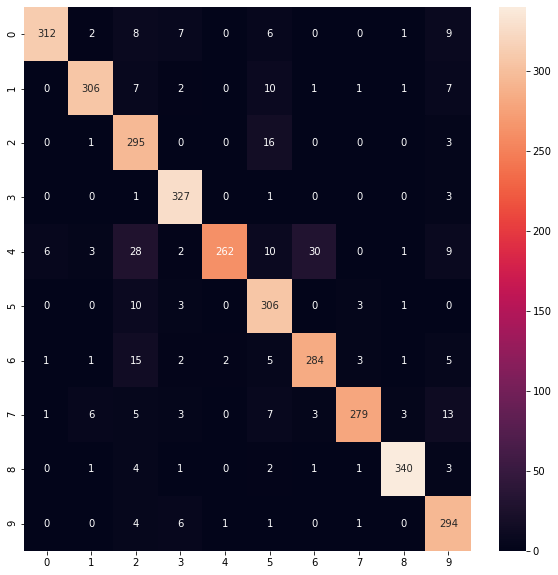

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm1 = confusion_matrix(test_label_names, mnb_predictions, labels=label_map_df['Label Name'].values)
plt.figure(figsize=(10,10))
sns.heatmap(cm1, annot=True, fmt='d')

# Using Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2', max_iter=100, C=1, random_state=42)
lr.fit(tv_train_features, train_label_names)
lr_tfidf_cv_scores = cross_val_score(lr, tv_train_features, train_label_names, cv=5)
lr_tfidf_cv_mean_score = np.mean(lr_tfidf_cv_scores)
print('Train Score (5-fold):', lr_tfidf_cv_scores)
print('Average Train Score:', lr_tfidf_cv_mean_score)
lr_tfidf_test_score = lr.score(tv_test_features, test_label_names)
print('Test Accuracy:', lr_tfidf_test_score)

Train Score (5-fold): [0.97761194 0.97910448 0.96641791 0.98283582 0.98059701]
Average Train Score: 0.9773134328358208
Test Accuracy: 0.9754545454545455


In [13]:
import model_evaluation_utils as meu
lr_predictions = lr.predict(tv_test_features)
unique_classes = list(set(test_label_names))
meu.get_metrics(true_labels=test_label_names, predicted_labels=lr_predictions)
meu.display_classification_report(true_labels=test_label_names, 
                                  predicted_labels=lr_predictions, classes=unique_classes)

Accuracy: 0.9755
Precision: 0.9755
Recall: 0.9755
F1 Score: 0.9754
              precision    recall  f1-score   support

    prostate       0.98      0.99      0.99       332
     thyroid       1.00      0.99      1.00       353
  oesophagus       0.96      0.96      0.96       319
        lung       0.99      0.99      0.99       345
       liver       0.94      0.96      0.95       323
cervix_uteri       0.97      0.97      0.97       320
     stomach       0.97      0.95      0.96       351
     bladder       0.98      0.97      0.98       307
      breast       0.99      1.00      0.99       335
  colorectal       0.97      0.97      0.97       315

    accuracy                           0.98      3300
   macro avg       0.98      0.98      0.98      3300
weighted avg       0.98      0.98      0.98      3300



<AxesSubplot:>

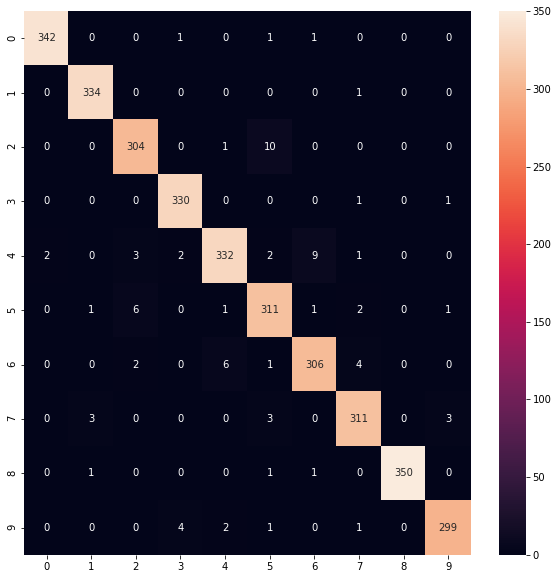

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm2 = confusion_matrix(test_label_names, lr_predictions, labels=label_map_df['Label Name'].values)
plt.figure(figsize=(10,10))
sns.heatmap(cm2, annot=True, fmt='d')

# Using Linear SVM

In [15]:
from sklearn.svm import LinearSVC

svm = LinearSVC(penalty='l2', C=1, random_state=42)
svm.fit(tv_train_features, train_label_names)
svm_tfidf_cv_scores = cross_val_score(svm, tv_train_features, train_label_names, cv=5)
svm_tfidf_cv_mean_score = np.mean(svm_tfidf_cv_scores)
print('Train Score (5-fold):', svm_tfidf_cv_scores)
print('Average Train Score:', svm_tfidf_cv_mean_score)
svm_tfidf_test_score = svm.score(tv_test_features, test_label_names)
print('Test Accuracy:', svm_tfidf_test_score)

Train Score (5-fold): [0.97910448 0.97761194 0.97014925 0.98656716 0.97835821]
Average Train Score: 0.9783582089552239
Test Accuracy: 0.9751515151515151


In [16]:
import model_evaluation_utils as meu
svm_predictions = svm.predict(tv_test_features)
unique_classes = list(set(test_label_names))
meu.get_metrics(true_labels=test_label_names, predicted_labels=svm_predictions)
meu.display_classification_report(true_labels=test_label_names, 
                                  predicted_labels=svm_predictions, classes=unique_classes)

Accuracy: 0.9752
Precision: 0.9753
Recall: 0.9752
F1 Score: 0.9751
              precision    recall  f1-score   support

    prostate       0.98      1.00      0.99       332
     thyroid       0.99      1.00      1.00       353
  oesophagus       0.96      0.96      0.96       319
        lung       0.99      0.99      0.99       345
       liver       0.94      0.98      0.96       323
cervix_uteri       0.97      0.95      0.96       320
     stomach       0.97      0.94      0.96       351
     bladder       0.99      0.97      0.98       307
      breast       0.99      0.99      0.99       335
  colorectal       0.97      0.97      0.97       315

    accuracy                           0.98      3300
   macro avg       0.97      0.97      0.97      3300
weighted avg       0.98      0.98      0.98      3300



<AxesSubplot:>

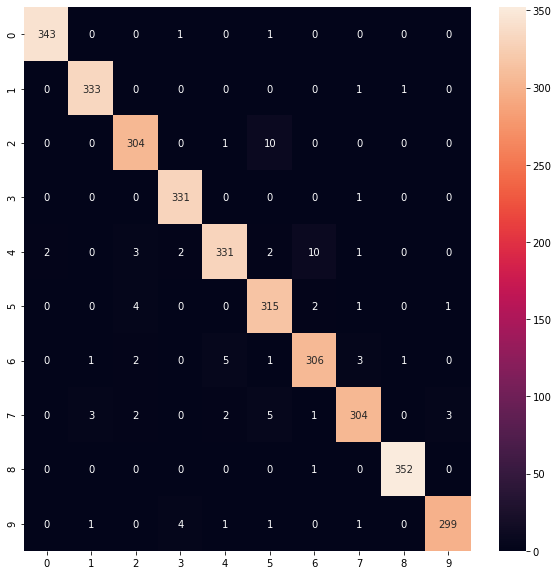

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm3 = confusion_matrix(test_label_names, svm_predictions, labels=label_map_df['Label Name'].values)
plt.figure(figsize=(10,10))
sns.heatmap(cm3, annot=True, fmt='d')

# Using Linear SVM (SGD)

In [18]:
from sklearn.linear_model import SGDClassifier

svm_sgd = SGDClassifier(loss='hinge', penalty='l2', max_iter=5, random_state=42)
svm_sgd.fit(tv_train_features, train_label_names)
svmsgd_tfidf_cv_scores = cross_val_score(svm_sgd, tv_train_features, train_label_names, cv=5)
svmsgd_tfidf_cv_mean_score = np.mean(svmsgd_tfidf_cv_scores)
print('Train Score (5-fold):', svmsgd_tfidf_cv_scores)
print('Average Train Score:', svmsgd_tfidf_cv_mean_score)
svmsgd_tfidf_test_score = svm_sgd.score(tv_test_features, test_label_names)
print('Test Accuracy:', svmsgd_tfidf_test_score)

C:\Users\Reza\anaconda3\envs\Text Mining\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\Reza\anaconda3\envs\Text Mining\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


Train Score (5-fold): [0.97985075 0.97537313 0.96865672 0.98507463 0.97835821]
Average Train Score: 0.9774626865671643
Test Accuracy: 0.9736363636363636


In [19]:
import model_evaluation_utils as meu
svm_sgd_predictions = svm_sgd.predict(tv_test_features)
unique_classes = list(set(test_label_names))
meu.get_metrics(true_labels=test_label_names, predicted_labels=svm_sgd_predictions)
meu.display_classification_report(true_labels=test_label_names, 
                                  predicted_labels=svm_sgd_predictions, classes=unique_classes)

Accuracy: 0.9736
Precision: 0.9738
Recall: 0.9736
F1 Score: 0.9736
              precision    recall  f1-score   support

    prostate       0.98      1.00      0.99       332
     thyroid       0.99      1.00      1.00       353
  oesophagus       0.94      0.96      0.95       319
        lung       0.99      1.00      1.00       345
       liver       0.94      0.97      0.96       323
cervix_uteri       0.98      0.95      0.96       320
     stomach       0.98      0.93      0.96       351
     bladder       0.99      0.97      0.98       307
      breast       0.98      0.99      0.99       335
  colorectal       0.96      0.96      0.96       315

    accuracy                           0.97      3300
   macro avg       0.97      0.97      0.97      3300
weighted avg       0.97      0.97      0.97      3300



<AxesSubplot:>

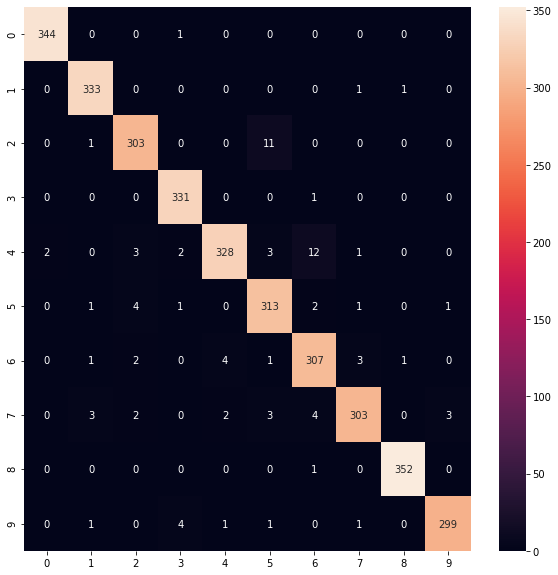

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm1 = confusion_matrix(test_label_names, svm_sgd_predictions, labels=label_map_df['Label Name'].values)
plt.figure(figsize=(10,10))
sns.heatmap(cm1, annot=True, fmt='d')

# Using Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=10, random_state=42)
rfc.fit(tv_train_features, train_label_names)
rfc_tfidf_cv_scores = cross_val_score(rfc, tv_train_features, train_label_names, cv=5)
rfc_tfidf_cv_mean_score = np.mean(rfc_tfidf_cv_scores)
print('Train Score (5-fold):', rfc_tfidf_cv_scores)
print('Average Train Score:', rfc_tfidf_cv_mean_score)
rfc_tfidf_test_score = rfc.score(tv_test_features, test_label_names)
print('Test Accuracy:', rfc_tfidf_test_score)

Train Score (5-fold): [0.88507463 0.88283582 0.90447761 0.89477612 0.90746269]
Average Train Score: 0.8949253731343283
Test Accuracy: 0.9103030303030303


In [22]:
import model_evaluation_utils as meu
rfc_predictions = rfc.predict(tv_test_features)
unique_classes = list(set(test_label_names))
meu.get_metrics(true_labels=test_label_names, predicted_labels=rfc_predictions)
meu.display_classification_report(true_labels=test_label_names, 
                                  predicted_labels=rfc_predictions, classes=unique_classes)

Accuracy: 0.9103
Precision: 0.9122
Recall: 0.9103
F1 Score: 0.9105
              precision    recall  f1-score   support

    prostate       0.94      0.93      0.94       332
     thyroid       0.96      0.92      0.94       353
  oesophagus       0.93      0.88      0.90       319
        lung       0.95      0.90      0.93       345
       liver       0.83      0.89      0.86       323
cervix_uteri       0.91      0.89      0.90       320
     stomach       0.93      0.86      0.89       351
     bladder       0.86      0.94      0.90       307
      breast       0.93      0.98      0.95       335
  colorectal       0.86      0.91      0.89       315

    accuracy                           0.91      3300
   macro avg       0.91      0.91      0.91      3300
weighted avg       0.91      0.91      0.91      3300



<AxesSubplot:>

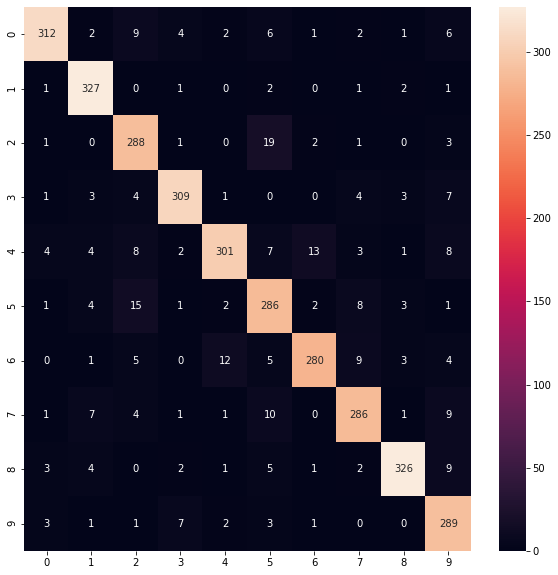

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm1 = confusion_matrix(test_label_names, rfc_predictions, labels=label_map_df['Label Name'].values)
plt.figure(figsize=(10,10))
sns.heatmap(cm1, annot=True, fmt='d')

# Using Gradient Boosted Machines

In [24]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=10, random_state=42)
gbc.fit(tv_train_features, train_label_names)
gbc_tfidf_cv_scores = cross_val_score(gbc, tv_train_features, train_label_names, cv=5)
gbc_tfidf_cv_mean_score = np.mean(gbc_tfidf_cv_scores)
print('Train Score (5-fold):', gbc_tfidf_cv_scores)
print('Average Train Score:', gbc_tfidf_cv_mean_score)
gbc_tfidf_test_score = gbc.score(tv_test_features, test_label_names)
print('Test Accuracy:', gbc_tfidf_test_score)

Train Score (5-fold): [0.97089552 0.9619403  0.96492537 0.97537313 0.96567164]
Average Train Score: 0.9677611940298508
Test Accuracy: 0.9672727272727273


In [25]:
import model_evaluation_utils as meu
gbc_predictions = gbc.predict(tv_test_features)
unique_classes = list(set(test_label_names))
meu.get_metrics(true_labels=test_label_names, predicted_labels=gbc_predictions)
meu.display_classification_report(true_labels=test_label_names, 
                                  predicted_labels=gbc_predictions, classes=unique_classes)

Accuracy: 0.9673
Precision: 0.9688
Recall: 0.9673
F1 Score: 0.9675
              precision    recall  f1-score   support

    prostate       0.97      1.00      0.99       332
     thyroid       0.99      1.00      0.99       353
  oesophagus       0.96      0.92      0.94       319
        lung       1.00      0.99      0.99       345
       liver       0.94      0.95      0.94       323
cervix_uteri       0.87      0.99      0.93       320
     stomach       0.98      0.94      0.96       351
     bladder       0.99      0.96      0.98       307
      breast       1.00      0.99      0.99       335
  colorectal       0.98      0.93      0.95       315

    accuracy                           0.97      3300
   macro avg       0.97      0.97      0.97      3300
weighted avg       0.97      0.97      0.97      3300



<AxesSubplot:>

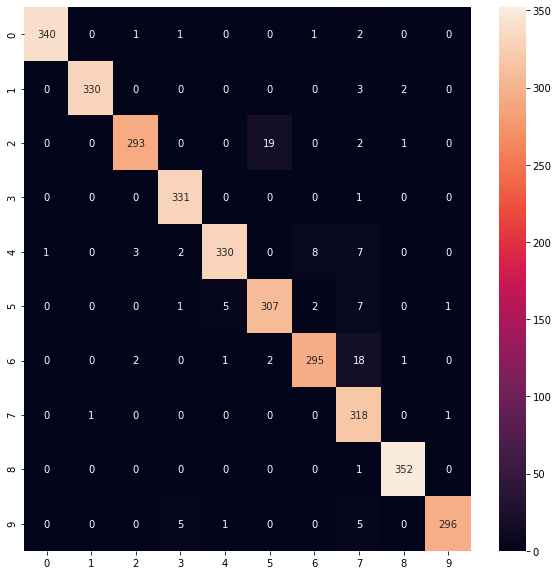

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm1 = confusion_matrix(test_label_names, gbc_predictions, labels=label_map_df['Label Name'].values)
plt.figure(figsize=(10,10))
sns.heatmap(cm1, annot=True, fmt='d')

# TF-IDF Classification Model Comparison

In [27]:
model_name = ['Naive Bayes', 'Linier Regression', 'SVM', 'SVM(SGD)', 'Random Forest', 'Gradient Boost Machine']
model_var = [mnb, lr, svm, svm_sgd, rfc, gbc]
for i in range(len(model_name)):
    x_predictions = model_var[i].predict(tv_test_features)
    unique_classes = list(set(test_label_names))
    print(model_name[i])
    meu.get_metrics(true_labels=test_label_names, predicted_labels=x_predictions)
    print()

Naive Bayes
Accuracy: 0.9106
Precision: 0.9179
Recall: 0.9106
F1 Score: 0.9107

Linier Regression
Accuracy: 0.9755
Precision: 0.9755
Recall: 0.9755
F1 Score: 0.9754

SVM
Accuracy: 0.9752
Precision: 0.9753
Recall: 0.9752
F1 Score: 0.9751

SVM(SGD)
Accuracy: 0.9736
Precision: 0.9738
Recall: 0.9736
F1 Score: 0.9736

Random Forest
Accuracy: 0.9103
Precision: 0.9122
Recall: 0.9103
F1 Score: 0.9105

Gradient Boost Machine
Accuracy: 0.9673
Precision: 0.9688
Recall: 0.9673
F1 Score: 0.9675



In [28]:
import time

mnb = MultinomialNB(alpha=1)
start = time.time()
mnb.fit(tv_train_features, train_label_names)
stop = time.time()
timemnb = str(round(stop-start,3)) + 's'
print('Training time: ', timemnb)

Training time:  0.024s


In [29]:
lr = LogisticRegression(penalty='l2', max_iter=100, C=1, random_state=42)
start = time.time()
lr.fit(tv_train_features, train_label_names)
stop = time.time()
timelr = str(round(stop-start,3)) + 's'
print('Training time: ', timelr)

Training time:  3.494s


In [30]:
svm = LinearSVC(penalty='l2', C=1, random_state=42)
start = time.time()
svm.fit(tv_train_features, train_label_names)
stop = time.time()
timesvm = str(round(stop-start,3)) + 's'
print('Training time: ', timesvm)

Training time:  0.183s


In [31]:
svm_sgd = SGDClassifier(loss='hinge', penalty='l2', max_iter=5, random_state=42)
start = time.time()
svm_sgd.fit(tv_train_features, train_label_names)
stop = time.time()
timesvm_sgd = str(round(stop-start,3)) + 's'
print('Training time: ', timesvm_sgd)

Training time:  0.046s


C:\Users\Reza\anaconda3\envs\Text Mining\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


In [32]:
rfc = RandomForestClassifier(n_estimators=10, random_state=42)
start = time.time()
rfc.fit(tv_train_features, train_label_names)
stop = time.time()
timerfc = str(round(stop-start,3)) + 's'
print('Training time: ', timerfc)

Training time:  0.899s


In [33]:
gbc = GradientBoostingClassifier(n_estimators=10, random_state=42)
start = time.time()
gbc.fit(tv_train_features, train_label_names)
stop = time.time()
timegbc= str(round(stop-start,3)) + 's'
print('Training time: ', timegbc)

Training time:  9.047s


In [36]:
y = pd.DataFrame([['Naive Bayes', 
               timemnb, mnb_tfidf_cv_mean_score, mnb_tfidf_test_score],
              ['Logistic Regression', 
               timelr, lr_tfidf_cv_mean_score, lr_tfidf_test_score],
              ['Linear SVM', 
               timesvm, svm_tfidf_cv_mean_score, svm_tfidf_test_score],
              ['Linear SVM (SGD)',  
               timesvm_sgd, svmsgd_tfidf_cv_mean_score, svmsgd_tfidf_test_score],
              ['Random Forest', 
               timerfc, rfc_tfidf_cv_mean_score, rfc_tfidf_test_score],
              ['Gradient Boosted Machines', 
               timegbc, gbc_tfidf_cv_mean_score, gbc_tfidf_test_score]],
             columns=['Model', 'Training Time', 'Train Score (TF-IDF)', 'Test Score (TF-IDF)'],
             )

In [37]:
y

,Model,Training Time,Train Score (TF-IDF),Test Score (TF-IDF)
0,Naive Bayes,0.024s,0.922537,0.910606
1,Logistic Regression,3.494s,0.977313,0.975455
2,Linear SVM,0.183s,0.978358,0.975152
3,Linear SVM (SGD),0.046s,0.977463,0.973636
4,Random Forest,0.899s,0.894925,0.910303
5,Gradient Boosted Machines,9.047s,0.967761,0.967273


In [38]:
y.to_csv (r'C:\Users\Reza\Desktop\save2.csv', index = False, header=True)